In [34]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import imageio.v2 as imageio
from matplotlib import pyplot as plt

In [2]:
%ls

'=2.0.7'        DATASET_MINI/            dlwpt-code/
 DATASET_BIG/   detectron2_learn.ipynb   output/


In [3]:
dataset_path = "./DATASET_BIG/dataset/"
annotations_path = "./DATASET_BIG/dataset/annotations.json"

In [ ]:
# Constants
N_EPOCHS = 30
BATCH_SIZE = 64
NUM_WORKERS = 32
NUM_CLASSES = 5 + 2  # (5 microbes + 2 defects)
LR = 1e-4
STEP_SIZE = int(N_EPOCHS / 3)
GAMMA = 0.1
DEVICE = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [112]:
# Data Preprocessing and Augmentation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    # transforms.RandomCrop(512),  # Random cropping
    transforms.RandomHorizontalFlip(),  # Random horizontal flipping
    transforms.RandomRotation(45),  # Random rotation within -45 to 45 degrees
    # transforms.RandomResizedCrop(512, scale=(0.8, 1.2)),  # Random scaling
    transforms.Resize(512),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

In [102]:
%ls

'=2.0.7'        DATASET_MINI/            dlwpt-code/
 DATASET_BIG/   detectron2_learn.ipynb   output/


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


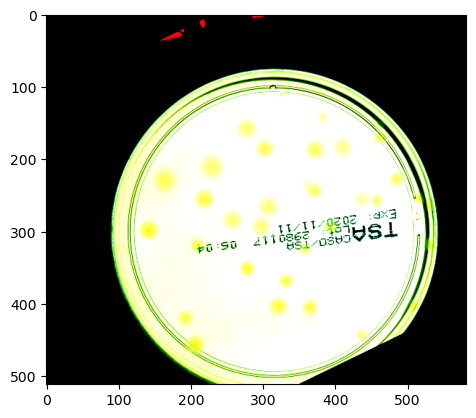

In [111]:
test_img = imageio.imread("./DATASET_BIG/dataset/3515.jpg")
test_img_t = transform(test_img)
plt.imshow(test_img_t.permute(2,1,0))

In [113]:
# Load AGAR Dataset (assuming COCO format)
dataset = datasets.CocoDetection(
    root=dataset_path,
    annFile=annotations_path,
    transform=transform)

loading annotations into memory...
Done (t=3.59s)
creating index...
index created!


In [114]:
# split dataset into train and test
train_size = int(0.75 * len(dataset))  # 75% for training
val_size = len(dataset) - train_size  # 25% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [115]:
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=NUM_WORKERS)

In [116]:
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

backbone = models.resnet50(weights=True)
backbone.out_channels = 2048

model = FasterRCNN(backbone, 
                   num_classes=NUM_CLASSES,
                   rpn_anchor_generator=anchor_generator)

/home/devuser/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [117]:
# Training Parameters
optimizer = optim.SGD(model.parameters(),
                      lr=LR,
                      momentum=0.9,
                      weight_decay=0.0005)

# Adjust step_size and gamma as needed
scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=STEP_SIZE,
    gamma=GAMMA)

In [118]:
def validation(model, val_loader):
    model.eval()  # Set model to evaluation mode

    all_preds = []
    all_targets = []

    with torch.no_grad():  # Disable gradient calculation
        for images, targets in val_loader:
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            outputs = model(images)  # Get model predictions

            for i in range(len(outputs)):
                pred_boxes = outputs[i]['boxes'].cpu().numpy()
                pred_scores = outputs[i]['scores'].cpu().numpy()
                pred_labels = outputs[i]['labels'].cpu().numpy()

                target_boxes = targets[i]['boxes'].cpu().numpy()
                target_labels = targets[i]['labels'].cpu().numpy()

                all_preds.append({
                    'boxes': pred_boxes,
                    'scores': pred_scores,
                    'labels': pred_labels
                })
                all_targets.append({
                    'boxes': target_boxes,
                    'labels': target_labels
                })

    # Calculate mAP using COCO API
    cocoGt = COCO(annotations_path)  # Load ground truth annotations
    cocoDt = cocoGt.loadRes(all_preds)  # Load predictions as COCO results

    cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

    mAP = cocoEval.stats[0]  # Extract mAP from COCOeval results

    # Calculate MAE and sMAPE
    mae = 0
    smape = 0
    for pred, target in zip(all_preds, all_targets):
        pred_count = len(pred['boxes'])
        target_count = len(target['boxes'])

        mae += abs(pred_count - target_count)
        smape += 100 * abs(pred_count - target_count) / (pred_count + target_count)

    mae /= len(all_preds)
    smape /= len(all_preds)

    return mAP, mae, smape

In [119]:
writer = SummaryWriter("./output")

# Training Loop
for epoch in range(N_EPOCHS):
    # Training
    model.train()
    for images, targets in train_loader:
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        writer.add_scalar("Loss/Total", losses.item(), epoch)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    scheduler.step()  # Update learning rate

    # Validation (calculate mAP, MAE, sMAPE)
    mAP, MAE, sMAPE = validation(model, val_loader)

    print("[{}] epoch: {}, mAP: {}, MAE: {}, sMAPE: {}".format(
        datetime.now(), epoch, mAP, MAE, sMAPE))

    # Log metrics to TensorBoard
    writer.add_scalar("mAP", mAP, epoch)
    writer.add_scalar("MAE", MAE, epoch)
    writer.add_scalar("sMAPE", sMAPE, epoch)

writer.close()

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/devuser/.local/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/devuser/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/home/devuser/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 277, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/devuser/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 144, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/home/devuser/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 144, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/home/devuser/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 121, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/home/devuser/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 173, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable


In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir ./output

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [ ]:
# Save the trained model
torch.save(model.state_dict(), "./microb_model.pth")